# CS145: Project 3 | An Analysis of Stack Overflow

---



## **Collaborators:**
Please list the names and SUNet IDs of your collaborators below:
* *Anna Yang, ayang7*
* *Julie Wang, jwang09*

## **Project Overview**

**Our central question is:** What are key factors that make a 'good' post on StackOverflow? 



In this project, we will explore the key factors that make a 'good' post. For our purposes, a 'good' post is simply a post with a high score (upvotes-downvotes); this refers to the number of StackOverflow users who have clicked downvote subtracted from the number of users who have clicked upvote on the specific post.  We will explore the ```stackoverflow``` dataset on BigQuery to examine factors that are correlated to a post having a high score. 

Some possible questions we may explore include: how does the length of a post affect its score? Do specific users tend to average higher scores? If so, what differentiates these users from others? 



## **Analysis of Dataset**

#### We will be using the `stackoverflow` dataset from BigQuery's public  dataset.

### **Overview of Dataset:**

This dataset contains information about the content on StackOverflow, such as registered users, questions that have been posted, and answers that have been posted. It has 16 tables, with a total size of 207.08 GB.  Due to the large number of tables, we have chosen to focus on 7 of the tables that contain information we believe would be interesting to analyze, which are as follows: 

1.   `badges` (1.57 GB) -- This table contains all the badges that have been given on StackOverflow, its corresponding user, and the badge type.  According to StackOverflow, badges are given on StackOverflow when a user is "being especially helpful". For example, a 'Teacher' badge is given to users who have answered a question with score of 1 or more.  The primary key of this table is `id` (badge id for a specific user).
2. `post_history` (97.57 GB) -- This table is the largest table in the dataset, and contains all revisions to posts that have been made.  It includes information such as the post that is being revised (`post_id`), the user revising it (`user_id`), the revised post, and any comments the user may have left to describe the revision. The primary key of this table is `id` (post revision id). 
3. `post_links` (263.8 MB) -- This table contains all links that have been posted, where the link links the user to another post.  Essentially, the link is to a related post.  The table includes the post_id, the link type, and the related_post_id. The primary key of this table is `id` (link id).  
4. `posts_answers` (24.67 GB) -- This table has all answers to questions posted. It includes each answer's content, the number of comments to the answer, the parent question id, the owner id, as well as view_count/score. The primary key of this table is `id` (answer id).
5. `posts_questions` (31.63 GB) -- This table contains all the questions posted on StackOverflow, and includes information about each question such as the title of the question, the question itself, the number of answers on the post, the number of comments on the post, tags, the number of people who have favorited the post, the owner, and the score.  The primary key of this table is `id`, representing a post id.  
6. `users` (2.02 GB) -- This table contains all registered users on StackOverflow, and includes information such as their age, reputation, creation_date, up_votes, down_votes, and views. The primary key of this table is `id`, representing a user's id (`user_id`). 
7. `tags` (2.32 MB) -- This table contains all tags in StackOverflow, and the count (the number of times they have been used).  The primary key of this table is `id`, representing a tag's id. 


### **Connection between Tables**

**How are badges associated with a user?**

The `badges` table is associated with the users table through the foreign key `user_id`, as each badge in the table belongs to a user.  

**If the `post_history` table contains all revisions to posts, does it contain posts with the same id?**

Yes, the `post_history` table has a primary key `id` that represents a *specific version* of a post.  However, it also is associated with the `posts_questions` table through the foreign key `post_id`.  Since a post may be revised multiple times, it's possible that the `post_history` table contains a post with a certain `post_id` multiple times (however, each of these revisions have their own `id` in this table).  The table is also associated with the user from the `users` table who is revising the post through `user_id`. 

**How are links associated with the post they're left on, and are they associated with the post they're referencing?**

The `post_links` table is connected to the `post_questions` table through the `post_id` foreign key.  This represents the post the link is in.  Since this link is a link to another post, the `related_post_id` represents the related post that the link leads to.  

**How do we know what post an answer was in response to?**

The `post_answers` table is connected to the `post_questions` table by the `parent_id`, which is the "parent" to the answer.  In other words, the `parent_id` represents the post the answer was meant for. The `post_answers` table is also connected to the `users` table through `owner_user_id`, representing the user who wrote the answer.  

**Does the `post_questions` table also contain information from the `post_answers` table?**

Yes, the `post_questions` table includes a column `accepted_answer_id`.  This id represents the answer that was accepted by the owner of the post, and is the foreign key that connects the two.  Similar to the `post_answers` table, the `post_questions` table is also connected to the `users` table through `owner_user_id`, representing the user who wrote the post. 

### **More Schema Comprehension**





**If we were given users and we wanted to know what tags they have contributed answers to, what tables should we use?**

We should use the `users` table to find each user's `id`, `posts_answers` to find all the answers a user has written and the corresponding parent post, and then `posts_questions` to find the tags for the parent post.  


**If we wanted to see how many answers the user with the most badges has contributed, what tables would we use?**

We should use the `badges` table to find the user with the most badges, and then the `posts_answers` table to see how many answers that user has posted.


**If we wanted to see whether the user with the highest number of upvotes has written more posts vs. contributed more answers, which tables do we need to use?**

We would need the `users` table to find the user with the highest number of upvotes, the `posts_answers` table to find the number of answers this user has contributed, and the `posts_questions` table to find the number of questions this user has posted.  


**If we wanted to see whether using multiple links would have an effect on a post's score, what tables should we use?**

We would want to use the `post_links` table to get the `id`'s for posts with links, and find the scores for those posts with the `posts_questions` table.  



## **Data Exploration**

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145dmds" # FOR JULIE
# project_id = 'cs145dmds-296003' # FOR ANNA

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Imports for visualization
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### **Initial Exploration of Repo Features**

To start exploring the dataset, we first created the following plots:
1. Badge Distribution
2. Post Length Distribution
3. Title Length Distribution
4. User Reputation Distribution
5. Answer Count Distribution for Posts
6. Favorite Count Distribution for Posts
7. Accepted Answer Score Distribution
8. Tag Distribution
9. The Distribution of the Number of Links in a Post
10. The Distribution of the Number of Revisions for a Post

Note that 'Post' refers to a question (`posts_questions`), and not a answer or a comment. 

#### 1) Badge Distribution

First, let's start off by taking a look at badge class distribution among users.  From the StackOverflow website, one "receives badges for being especially helpful.  Badges appear on your profile page, flair, and your posts". Badges are split into 3 different classes — bronze, silver, and gold.  Bronze badges are relatively easy to get and encourage users to try out features of the website. Silver badges are less common, and can be earned for asking great questions or giving great answers.  Gold badges are the most difficult — examples of gold badges include “Socratic — Ask a well-received question on 100 separate days”, or “Great Answer — Answer score of 100 or more” (StackOverflow).  Let’s start by taking a look at the distribution for the 3 different badge classes, before going into more depth and looking at the distribution for all the different badges.  

In [ ]:
%%bigquery --project $project_id explore_1a
  SELECT COUNTIF(class=1)/COUNT(*) as gold, 
        COUNTIF(class=2)/COUNT(*) as silver, 
        COUNTIF(class=3)/COUNT(*) as bronze
  FROM `bigquery-public-data.stackoverflow.badges` 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


<Figure size 792x504 with 0 Axes>

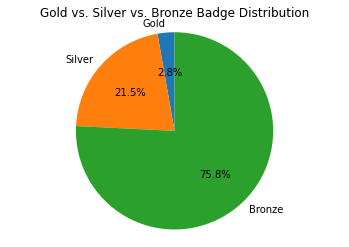

In [ ]:
plt.figure(figsize=(11,7))

labels = ['Gold', 'Silver', 'Bronze']
sizes = [explore_1a['gold'], explore_1a['silver'], explore_1a['bronze']]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title("Gold vs. Silver vs. Bronze Badge Distribution")
plt.show()

Now, let's take a more in-depth look at badge distribution among users.  There are many types of badges ranging from question badges such as "Inquisitive - ask a well-received question on 30 separate days, and maintain a positive question record", to answer badges such as "Nice Answer - Answer score of 10 or more",  to Participation badges such as "Enthusiast - Visit the site each day for 30 consecutive days", and even to Moderation badges such as "Peer Pressure - Delete your own post with a score of -3 or lower".  

In [ ]:
%%bigquery --project $project_id explore_1b
  SELECT name, COUNT(name) as count
  FROM `bigquery-public-data.stackoverflow.badges` 
  GROUP BY name
  ORDER BY count DESC
  LIMIT 30

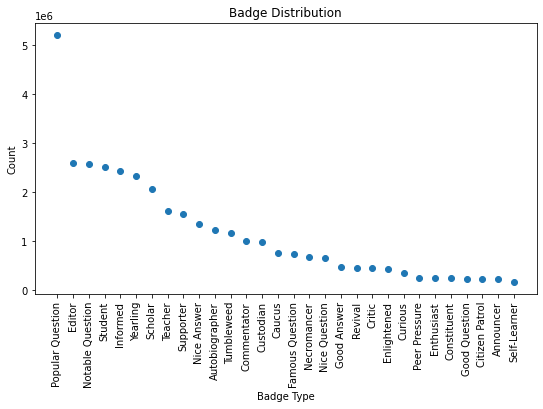

In [ ]:
plt.figure(figsize=(9,5))
plt.scatter(explore_1b['name'], explore_1b['count'])
plt.title("Badge Distribution")
plt.xlabel("Badge Type")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

**How might badges affect a post score?**

As an example of how badges may affect a post score, a user having a Great Question badge may imply that they have a history of asking great questions, and people may pay attention to this user's questions.  This may then affect their post score if they made a new post.  We predict that badges that are less related to a user's questions and answers are more unlikely to affect a post score.

**If badges impact post score, would you expect all badges to have the same impact?**

No, we do not expect all badges to have the same impact.  As noted earlier, there are many types of badges on StackOverflow, ranging from very basic and 'easier' to get, to extremely difficult to get.  For example, Popular Question is the most awarded badge -- users with a "question with 1,000 views" is awarded this badge.  Given the large number of people using StackOverflow everyday, it is likely that this is not a difficult badge to get, hence its popularity.  If so many people have this badge, it is not likely to have a significant impact on a post score.  On the other hand, Good Question is on the bottom end of the top 30 badges -- this badge is given for users with a question that has a "Question score of 25 or more".  Great Question (100 or more) does not even show up on the top 30 list.  We predict that the Question and Answer badges that are more rare are more likely to have an impact on a User's post score.  

#### 2) Post (Question) Length Distribution

Next, let's look at the distribution of the length of posts.  This could provide us some insight into how long an average post on StackOverflow is, which can be useful for when we start exploring how these features correlate to a post's score.    




In [ ]:
%%bigquery --project $project_id explore_2
  SELECT LENGTH(body) as len, COUNT(LENGTH(body)) as count
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  GROUP BY len
  ORDER BY count DESC

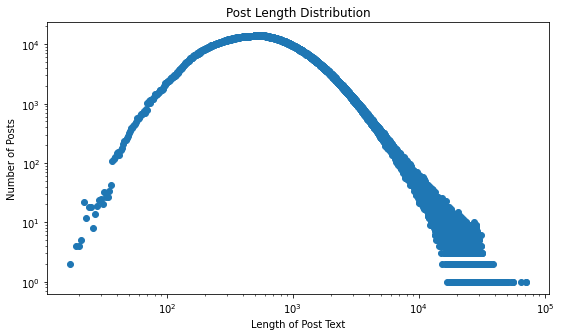

In [ ]:
plt.figure(figsize=(9,5))
plt.scatter(explore_2['len'], explore_2['count'])
plt.title("Post Length Distribution")
plt.xlabel("Length of Post Text")
plt.ylabel("Number of Posts")
plt.xscale('log')
plt.yscale('log')
# plt.xlim(right=10000)
plt.show()

**What is the average post length?**

From our plot, we can see that the average post length is around 700-1200 characters; however, post lengths can vary drastically.  We can see that while most post lengths are at least 50 characters, there are some posts with less than 25 characters.  On the other end of the spectrum, there are multiple posts with more than 10,000 characters, with a few even getting close to 100,000 characters in length. 


**How might post length affect a post's score?**

We predict that shorter posts will have higher scores. This is because of a few reasons: 

(1) It is possible that posts with a long length may have chunks of code copied and pasted in.  However, people who are answering likely do not want to look directly at code and "do your homework for you", so they may not want to answer these questions and may possibly downvote (or not give an upvote) to these questions.  Furthermore, these types of posts are likely very specific to a problem, which means general users may not find them helpful.  
(2) Many people may see a long post and not want to read it.  They may find it to be too much of a hassle, or too time-consuming.  

While we believe shorter posts are more likely to have higher scores, we do believe that extremely short posts that do not provide any context for a problem likely will not have a high score either. Thus, it will be interesting to see the correlation between the length of a post and post score in the next subsection - 'What Makes a Good Post?'.

#### 3) Title Length Distribution

While we now know the approximate length of an average StackOverflow post, we don't know anything about the title length distribution.  Since titles can also vary significantly in length, finding the title length distribution can provide us with some good insight into how long an average title is. We can then explore this more by seeing how that correlates with a 'good' post in the next sub-section.  



In [ ]:
%%bigquery --project $project_id explore_3
  SELECT LENGTH(title) as len, COUNT(LENGTH(title)) as count
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  GROUP BY len
  ORDER BY count DESC

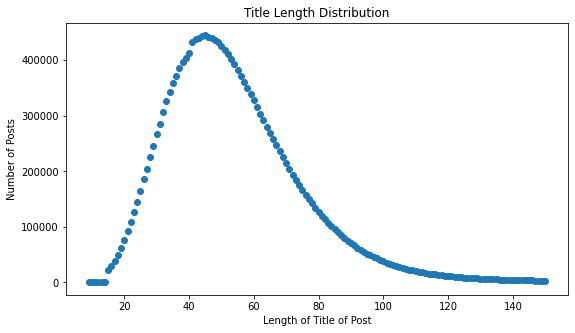

In [ ]:
plt.figure(figsize=(9,5))
plt.scatter(explore_3['len'], explore_3['count'])
plt.title("Title Length Distribution")
plt.xlabel("Length of Title of Post")
plt.ylabel("Number of Posts")
plt.show()

**What is the average title length?**

The average title length is around 40-50 characters.  However, as is the same with post length, some posts may have very short titles or very long titles, going all the way up to around 150 characters.  


**How might title length affect a post's score?**

Similar to post length, we predict that posts with shorter title lengths will have higher scores.  It is likely that a shorter title length summarizes the problem more concisely, and thus, more users may take notice of it.  

#### 4) User Reputation Distribution

Now let's take a look at the distribution of user reputation scores in StackOverflow.  Note that user reputation score is for a specific user and is calculated by StackOverflow. It is not the same as post score (what we're exploring), which is the number of upvotes - the number of downvotes for a single post. 

In [ ]:
 %%bigquery --project $project_id explore_4
    SELECT reputation, COUNT(reputation) as count
    FROM `bigquery-public-data.stackoverflow.users`
    GROUP BY reputation
    ORDER BY count DESC

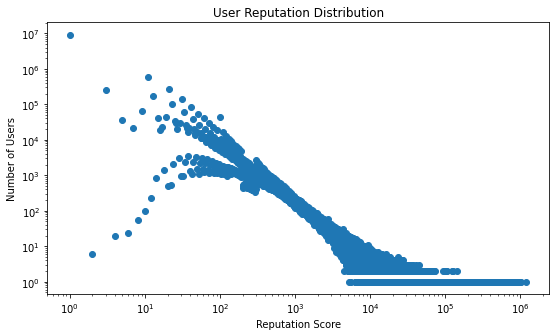

In [ ]:
plt.figure(figsize=(9,5))
plt.scatter(explore_4['reputation'], explore_4['count'])
plt.title("User Reputation Distribution")
plt.xlabel("Reputation Score")
plt.ylabel("Number of Users")
plt.xscale('log')
plt.yscale('log')
plt.show()

**What is the most common reputation score among users?**

The most common reputation for users by far is 1 (9,315,010 users).  As seen from the plot, the majority of users do not have a reputation score higher than 10^2.  While ~10^7 users have a reputation score of 1, ~10 users have a reputation score of 10000.  

**How might a user's reputation score be correlated with post score?**

A user having a very high reputation may be an indication that they ask useful questions, so we believe that a high reputation score will be correlated with a high post score.  However, it is also possible that a user with high reputation may not ask many questions at all, or may not ask 'good' questions -- they may have a high reputation because their answers are useful or due to other forms of participation.  In that case, the two may not be as correlated as we think -- this is something we should look into in the next section beyond the initial exploration.

#### 5) Answer Count Distribution for Posts


Now let's take a look at the answer count distribution on StackOverflow.  This will give us some insight into how many answers most posts typically get. 

In [ ]:
%%bigquery --project $project_id explore_5
  SELECT answer_count, COUNT(answer_count) as count
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  GROUP BY answer_count
  ORDER BY count DESC

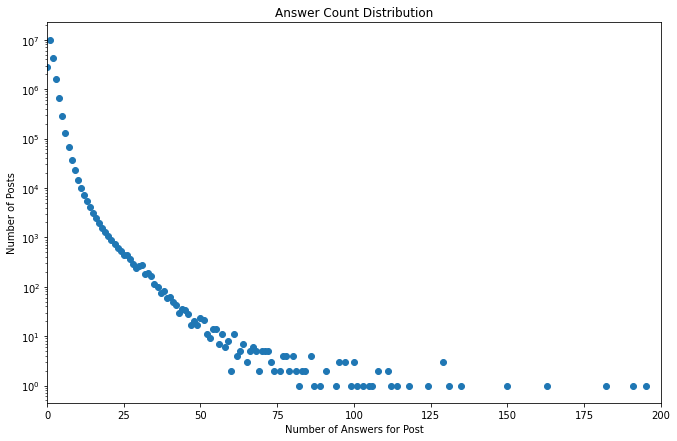

In [ ]:
plt.figure(figsize=(11,7))
plt.scatter(explore_5['answer_count'], explore_5['count'])
plt.title("Answer Count Distribution")
plt.xlabel("Number of Answers for Post")
plt.ylabel("Number of Posts")
plt.xlim(0,200)
plt.yscale('log')
plt.show()

**How might answer count affect a post's score?**

Answer count can be an indicator of how many people have paid attention to the post.  We predict that a high answer count may be correlated with a high post score, as it may show that many people are interested in this question.  However, something we want to keep in mind is that controversial posts can also lead to a high answer count, and may not have high scores as they may have many downvotes as well.  

#### 6) Favorite Count Distribution for Posts

Let's also take a look at the favorite count distribution for posts.  

In [ ]:
%%bigquery --project $project_id explore_6
  SELECT favorite_count, COUNT(favorite_count) as count
  FROM `bigquery-public-data.stackoverflow.posts_questions` 
  GROUP BY favorite_count
  ORDER BY count DESC

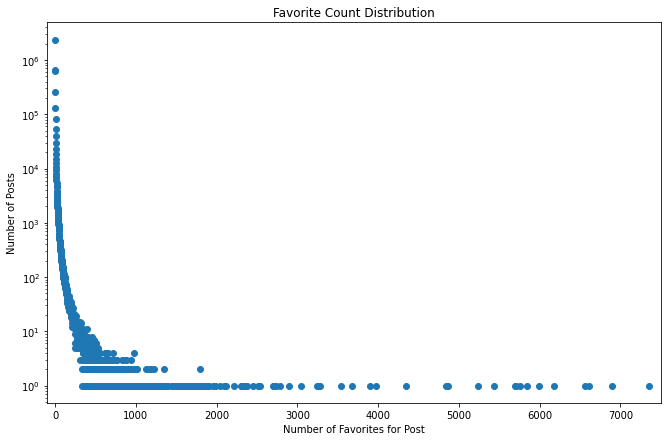

In [ ]:
plt.figure(figsize=(11,7))
plt.scatter(explore_6['favorite_count'], explore_6['count'])
plt.title("Favorite Count Distribution")
plt.xlabel("Number of Favorites for Post")
plt.ylabel("Number of Posts")
plt.xlim(-100, 7500)
plt.yscale('log')
plt.show()

**How might favorite count affect a post's score?**

Intuitively, favorite count is likely pretty directly correlated with a post's score.  Both are indications that a viewer of the post is interested in the question and think that it is a good question.  

#### 7) Accepted Answer Score

Next, let's look at Accepted Answers for Posts.  First, let's take a look at how many posts have accepted answers vs. have not accepted answers to see if post owners commonly accept answers.

In [ ]:
 %%bigquery --project $project_id explore_7a
 SELECT COUNTIF(accepted_answer_id IS NULL)/COUNT(*) as no_accepted, 
        COUNTIF(accepted_answer_id IS NOT NULL)/COUNT(*) as accepted
 FROM `bigquery-public-data.stackoverflow.posts_questions`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


<Figure size 792x504 with 0 Axes>

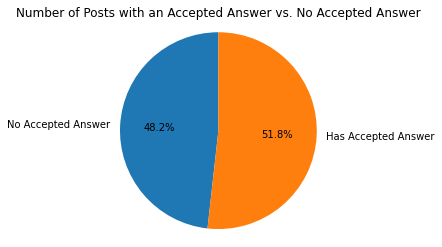

In [ ]:
plt.figure(figsize=(11,7))

labels = 'No Accepted Answer', 'Has Accepted Answer'
sizes = explore_7a['no_accepted'], explore_7a['accepted']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title("Number of Posts with an Accepted Answer vs. No Accepted Answer")
plt.show()

Now, let's look at the score distribution for accepted answers. 

In [ ]:
%%bigquery --project $project_id explore_7b
  SELECT a.score, COUNT(a.score) as count
  FROM `bigquery-public-data.stackoverflow.posts_questions` q
  JOIN `bigquery-public-data.stackoverflow.posts_answers` a ON q.accepted_answer_id=a.id
  WHERE q.accepted_answer_id IS NOT NULL
  GROUP BY a.score
  ORDER BY count DESC

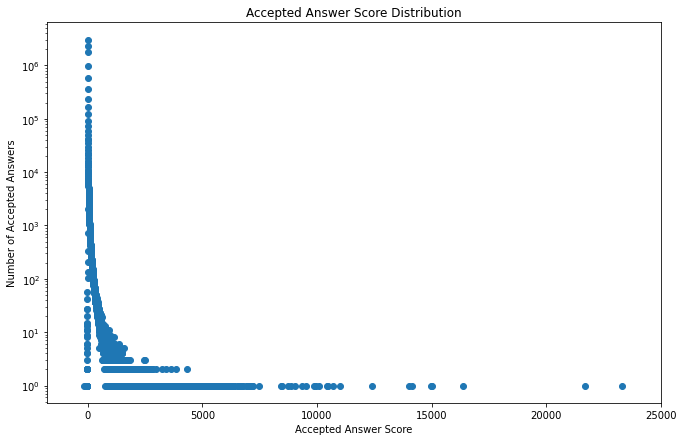

In [ ]:
plt.figure(figsize=(11,7))
plt.scatter(explore_7b['score'], explore_7b['count'])
plt.title("Accepted Answer Score Distribution")
plt.xlabel("Accepted Answer Score")
plt.ylabel("Number of Accepted Answers")
plt.yscale('log')
plt.xlim(right=25000)
plt.show()

**Do most posts have accepted answers?** 

While more posts *do* have accepted answers, we can see from the pie chart that many posts do not have accepted answers.  This might be because the user (owner of the post) has not gone through to accept a specific answer, or that there may be many answers that they like, or that there are no answers on their post.  

**What might a high accepted answer score imply about a post?**

A high accepted answer score may imply that the post was viewed by a lot of people, and that the answer helped a lot of people.  This could be correlated with a high scoring post, as an answer helping a lot of people may mean that a lot of people had the same question.  

#### 8) Tag Distribution

Now let's take a look at what the tag distribution is like across posts.  Through this, we can get a sense of what the most popular and most commonly used tags are, and also see what types of tags are commonly used.  

In [ ]:
%%bigquery --project $project_id explore_8
  SELECT tag_name, count
  FROM `bigquery-public-data.stackoverflow.tags` 
  ORDER BY count DESC
  LIMIT 30

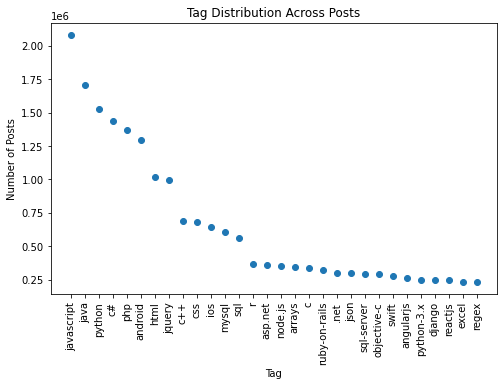

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(explore_8['tag_name'], explore_8['count'])
plt.title("Tag Distribution Across Posts")
plt.xlabel("Tag")
plt.ylabel("Number of Posts")
plt.xticks(rotation='vertical')
plt.show()

**What tag types are commonly used?**

From our plot, we can see that the most commonly used tags are language tags.  For example, `javascript`, `python`, `java`, `php`, are all commonly used languages around the world.  While specific topics such as `arrays` or `regex` also appear in the top 30 tags, it seems that users tend to categorize posts by language most often.  To confirm this, we looked a little further into the top 100 and found `database` at #40, `string` at #44, `list` at #57, and `csv` at #93, showing that while users may categorize by data types as well, they typically may categorize by language first.  Intuitively, this makes sense as syntax may differ significantly between languages, and someone asking a question about a `list` may want it to be clear that they're asking about lists in a specific language, such as `Python`.  

**How might tags affect a post's score?**

While we'll analyze this closer in the deeper exploration section where we compare features to score, we predict that more common tags may average higher scores.  This is because more common tags like `javascript` or `python` may be common topics for discussion, leading to more people searching for or answering questions for those posts.  

#### 9) The Distribution of the Number of Links in a Post

Let's also look at the distribution of the number of links in a post.  Through this, we can get a sense of the typical number of links, which often reference related StackOverflow posts, used in a post. 

In [ ]:
%%bigquery --project $project_id explore_9
  SELECT num_links, COUNT(num_links) as count
  FROM (SELECT post_id, COUNT(id) as num_links
    FROM `bigquery-public-data.stackoverflow.post_links` 
    GROUP BY post_id
    ORDER BY num_links DESC)
  GROUP BY num_links
  ORDER BY count DESC

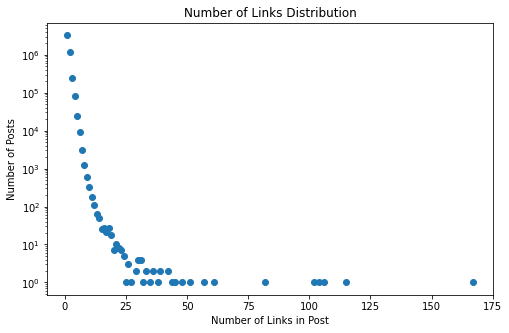

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(explore_9['num_links'], explore_9['count'])
plt.title("Number of Links Distribution")
plt.xlabel("Number of Links in Post")
plt.ylabel("Number of Posts")
plt.yscale('log')
plt.show()

**What is the overall trend for the distribution? Why might that be?**

We can see that the majority of posts include 0-5  links, with the graph having an overall downwards trend as the number of links increases.  This makes sense intuitively since people typically link posts to refer to a previous related answer, and it's unlikely that someone who has already found many related posts would be posting the question (whether it's because they didn't bother looking for related posts, or because there were no related posts on the topic).  

#### 10) The Distribution of the Number of Revisions for a Post

For the last initial exploratoration feature, let's look at the distribution of the number of revisions for a post, to gain some insight into if people often revise their posts, and how often they do so.  

In [ ]:
%%bigquery --project $project_id explore_10
  SELECT num_revisions, COUNT(num_revisions) as count
  FROM (SELECT post_id, COUNT(post_id) as num_revisions
        FROM `bigquery-public-data.stackoverflow.post_history` 
        GROUP BY post_id)
  GROUP BY num_revisions
  ORDER BY count DESC

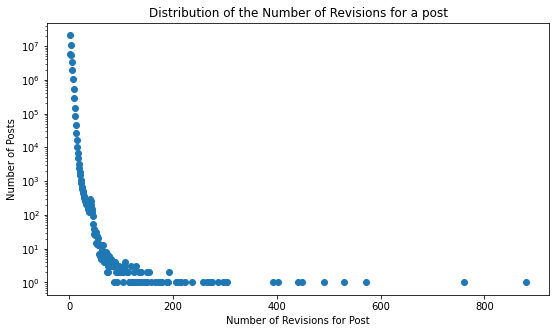

In [ ]:
plt.figure(figsize=(9,5))
plt.scatter(explore_10['num_revisions'], explore_10['count'])
plt.title("Distribution of the Number of Revisions for a post")
plt.xlabel("Number of Revisions for Post")
plt.ylabel("Number of Posts")
plt.yscale('log')
plt.show()

**Could the number of revisions be correlated with a post's score?** 

We predict that the number of revisions is slightly correlated with a post's score, with a large number of revisions being an indicator of a lower post score.  This is because a large number of revisions may indicate that the post was not very clear or had a lot of typos in the beginning, which may result in the post having a lower score.  It can also indicate that the user is trying to add more clarifications for possible answerers, whether that is because people asked for clarifications or because no one is answering. 

### **What Makes a Good Post on StackOverflow?**

As we noted earlier in the overview, for our project, a 'good' post is simply a post with a high score (# of upvotes - # of downvotes).  In this section, we will build off the features we explored in the earlier sub-section to see if we can find correlations between those features and a post being 'good'.  We will be reviewing some of our predictions from the last section, and analyze why each of these features may or may not be correlated.  

Specifically, we will examine how the score correlates with:
1. Type of Badge a User Has
2. Post Content Length
3. Post Title Length
4. A Post's User Average Score
5. Answer Count
6. Favorite Count
7. Accepted Answer's Score
8. Tag Names Used
9. The Number of Links to a Related Post
10. The Number of Revisions a Post Has


### 1) Types of User Badges

First, let's take a look at the correlation between the types of user badges and the average scores for these users.  Let’s start by looking at the class of the badge.  As mentioned earlier, there are 3 badge classes - bronze (3), silver (2), and gold (1). 

In [ ]:
%%bigquery --project $project_id feature_1a
  SELECT ROUND(AVG(score), 2) as avg_score
  FROM (SELECT posts.score, badges.name
        FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
        JOIN `bigquery-public-data.stackoverflow.badges` as badges
        ON posts.owner_user_id = badges.user_id
        WHERE tag_based IS FALSE AND badges.class = 1) as sub
  UNION ALL
  SELECT ROUND(AVG(score), 2) as avg_score
  FROM (SELECT posts.score, badges.name
        FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
        JOIN `bigquery-public-data.stackoverflow.badges` as badges
        ON posts.owner_user_id = badges.user_id
        WHERE tag_based IS FALSE AND badges.class = 2) as sub
  UNION ALL
  SELECT ROUND(AVG(score), 2) as avg_score
  FROM (SELECT posts.score, badges.name
        FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
        JOIN `bigquery-public-data.stackoverflow.badges` as badges
        ON posts.owner_user_id = badges.user_id
        WHERE tag_based IS FALSE AND badges.class = 3) as sub

Text(0, 0.5, 'Average Score')

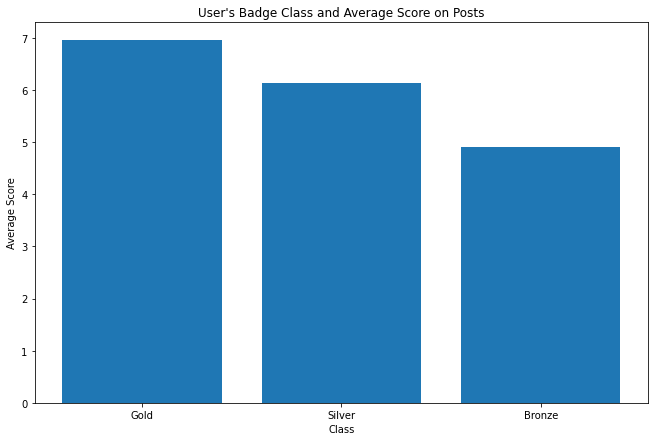

In [ ]:
plt.figure(figsize=(11, 7))
labels = ['Gold', 'Silver', 'Bronze']
plt.bar(labels, feature_1a['avg_score'])
plt.title("User's Badge Class and Average Score on Posts")
plt.xlabel("Class")
plt.ylabel("Average Score")

As similar to the initial exploration, let's now look more in-depth at specific badge types and see whether there is a correlation between a specific badge type and post score. 

In [ ]:
feature_1b = pd.io.gbq.read_gbq('''
  SELECT ROUND(AVG(score), 2) as avg_score, name as badge_type
  FROM (SELECT posts.score, badges.name
        FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
        JOIN `bigquery-public-data.stackoverflow.badges` as badges
        ON posts.owner_user_id = badges.user_id
        WHERE tag_based IS FALSE AND badges.class = 3) as sub
  GROUP BY name
  ORDER BY avg_score DESC 
  LIMIT 20
''', project_id='cs145dmds-296003', dialect='standard')

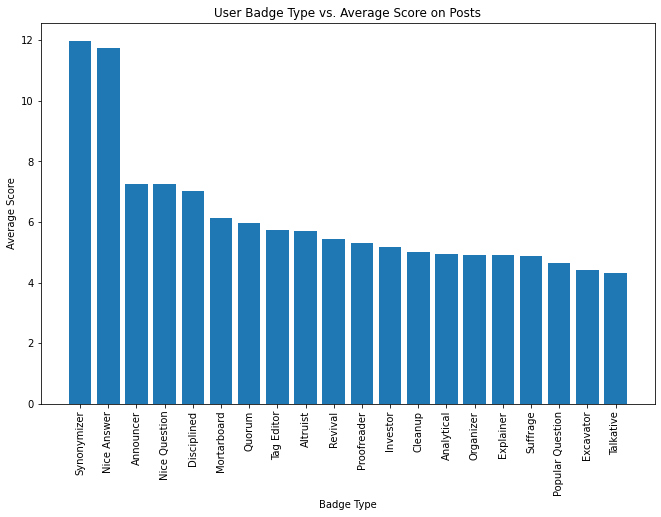

In [ ]:
plt.figure(figsize=(11, 7))
plt.bar(feature_1b['badge_type'], feature_1b['avg_score'])
plt.title("User Badge Type vs. Average Score on Posts")
plt.xlabel("Badge Type")
plt.ylabel("Average Score")
plt.xticks(rotation='vertical')
plt.show()

**Are there any correlations between the user badge class and the user's average score on posts?**

We can see that badge class does have a correlation with post score from Feature Figure 1a.  Users with a gold badge have on average, higher scores on posts compared to users with a silver badge, who have on average, higher scores on posts compared to users with a bronze badge.  Intuitively, this makes sense, as silver and gold badges are given to users who have given good answer(s) and who have asked insightful questions.  

**Do users with a specific badge average higher scores?**

From our second plot, we can see that users with the Synonymizer badge and Nice Answer badge appear to average higher post scores.  This is interesting to see because the Synonymizer badge is a bronze-level badge awarded to users who have an approved tag synonym.  At first glance, this badge doesn't seem like it would be correlated with a higher score; however, the synonymizer badge does not appear to be a common badge as seen from our badge distribution plots earlier in the initial exploration.  As they are not common badges, it is possible that users with the Synonymizer badge are ardent StackOverflow users -- which may lead to the higher average post score.  Intuitively, users with the Nice Answer badge may have a higher post score as they are likely to be users who try to answer **and** post as insightfully as possible.

**Did our prediction that rare Question and Answer badges are likely to have an impact on a User's post score hold?**

Rather than rare Question and Answer badges, it appears that Moderation badges such as Tag Editor or Proofreader, or Participation badges such as Quorum actually have more of a correlation to a high User's average post score. This is possibly because users who are moderating or actively participating may use StackOverflow more, and may be more familiar with what 'good' posts or good answers look like.  

### 2) Post Content Length


Next, let’s look at how post content length correlates with post score.  As mentioned earlier, post length is the length of the text body of the post, and does not include the title.  

In [ ]:
feature_2 = pd.io.gbq.read_gbq('''
  SELECT LENGTH(body) as content_length, ROUND(AVG(score), 2) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE body IS NOT NULL
  GROUP BY content_length
''', project_id='cs145dmds-296003', dialect='standard')

(-5.0, 40.0)

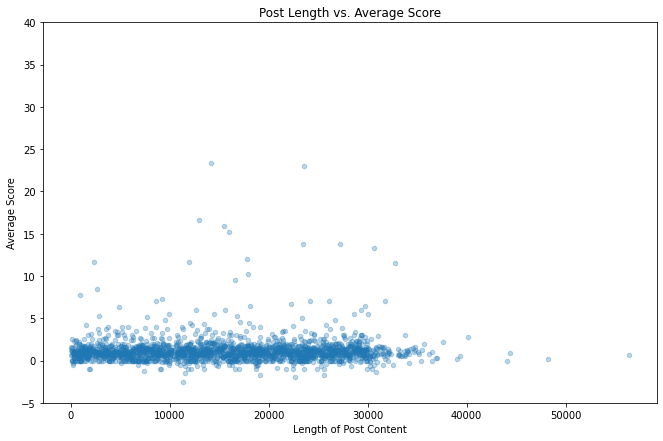

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature_2["content_length"].sample(n=2000), feature_2["avg_score"].sample(n=2000), s=20, alpha=0.30)
plt.title("Post Length vs. Average Score")
plt.xlabel("Length of Post Content")
plt.ylabel("Average Score")
plt.ylim(-5, 40)


**What is the overall trend for the distribution? Why might the trend be less subtle here as compared to other features?**

Contrary to what we had predicted in the inital explorations, there does not appear to be a significant correlation between post content length and average post score. Although higher score averages tend to fall within lower ranges of content length, we cannot conclude that there is a relationship between the two factors because most of the data points fall below the average score of 5. Post length might not affect the score as much as we predicted due to several reasons: question length is highly dependent on the topic (for example, some topics have a lot of content dedicated to just code, while others might just need one or two lines of description but still garner a lot of upvotes).

### 3) Post Title Length


Now let’s look at how post title length relates with a post’s score.  

In [ ]:
%%bigquery --project $project_id feature3
  SELECT LENGTH(title) as title_len, score
  FROM `bigquery-public-data.stackoverflow.posts_questions`
  WHERE title IS NOT NULL

Text(0, 0.5, 'Post Score')

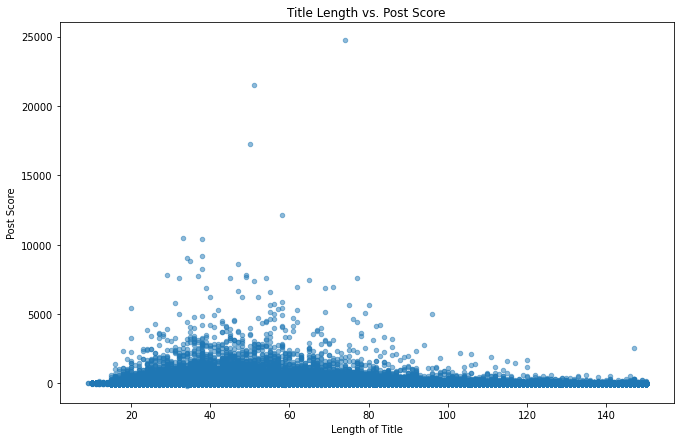

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature3["title_len"], feature3["score"], s=20, alpha=0.50)
plt.title("Title Length vs. Post Score")
plt.xlabel("Length of Title")
plt.ylabel("Post Score")

**Did the trend match with our prediction in the initial explorations? What is the difference in trend here as compared to post content length? How might it affect the average score?**

The trend shows us that shorter titles are more likely to achieve a higher post score, agreeing with our initial prediction. The trend is more apparent here than when looking at post content, and we see that titles of length 20 to 80 correspond to the highest average scores. In our initial explorations we see that the most of the titles have a length between similar numbers. Due to the fact that many posts share the same title length, average scores can be biased towards the higher end to account for posts with super high individual scores. 

The more prominent trend in the title might also be because while the content itself might be dependent on the question topic at hand, the title might be reflective of how well the question is summarized in a reasonable amount of words, so that people reading it can quickly and efficiently get an idea of what the entire post is about. A post with too long of a title can be convoluted and hard to search for.


### 4) A Post's User Score

Now, let’s see how a user’s reputation, calculated by StackOverflow as an indication of how trustworthy that user’s posts/activities is to the community, correlates with post score. 

In [ ]:
feature4 = pd.io.gbq.read_gbq(''' 
  SELECT reputation as user_score, AVG(posts.score) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  JOIN `bigquery-public-data.stackoverflow.users` as users ON posts.owner_user_id = users.id
  GROUP BY posts.owner_user_id, reputation
''', project_id='cs145dmds-296003', dialect='standard')

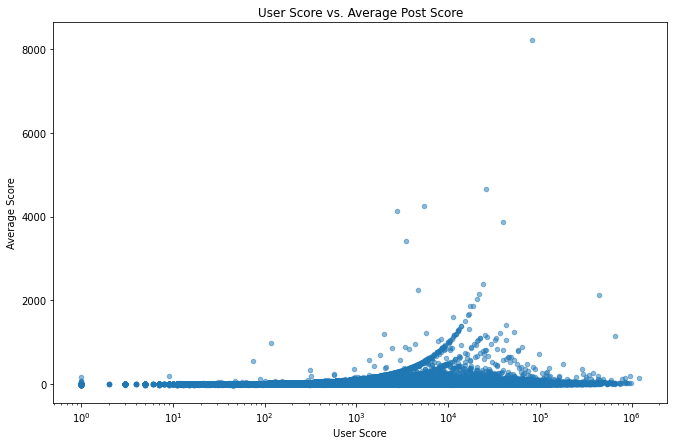

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature4["user_score"], feature4["avg_score"], s=20, alpha=0.50)
plt.title("User Score vs. Average Post Score")
plt.xlabel("User Score")
plt.ylabel("Average Score")
plt.xscale('log')

**Is this trend informative? How does it answer our central question on ‘good’ posts?**

While posts written by users with a reputation score of below 100 average low scores, the trend is less consistent for users with reputations of above 100, in which we see that significantly more users have higher average post scores. However, we also see that there are still users with 10 or less average scores on posts. This might be because those particular users contribute to the StackOverflow community through other ways, such as answering or moderating. 

### 5) Answer Count

Now that we have an idea of how the length of a post title and content affects a post’s score, let’s shift our focus to answers, and how they may affect a post score.  Let’s start by taking a look at answer counts for posts.  

In [ ]:
%%bigquery --project $project_id feature5
  SELECT score, num_answers
  FROM (
    SELECT COUNT(answers.id) as num_answers, posts.score as score
    FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
    JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers
    ON answers.parent_id = posts.id
    GROUP BY posts.id, score
  ) as sub
  

(0.0, 250.0)

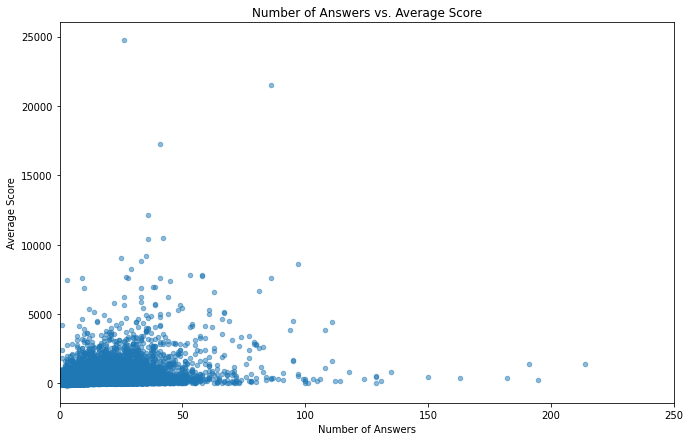

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature5["num_answers"], feature5["score"], s=20, alpha=0.50)
plt.title("Number of Answers vs. Score")
plt.xlabel("Number of Answers")
plt.ylabel("Post Score")
plt.xlim(0, 250) #outliers are excluded

**Does this trend match with our prediction?**

We will look at the range where the most posts are concentrated in -- 0 - 50 number of answers. Here we see that the trend matches with our prediction that posts with high number of answers are more likely to have higher scores. This is because in the scatterplot, posts with around 25 - 40 answers have greater datapoints in the higher score ranges, aligning with the observation that posts with higher engagement and a greater number of answers often leads to the post having a higher score. 

**Why might some of the posts with a large number of answers have such a low average score?**

As we can see from the scatterplot, some posts with over 100 answers have very low average scores.  As mentioned earlier in the initial exploration, this might be because highly controversial posts may have lots of answers.  However, these highly controversial posts are also likely to have a large number of downvotes, which may even out the large number of upvotes. 

### 6) Favorite Count

Let's also take a look at how favorite count might relate to a post score.  

In [ ]:
%%bigquery --project $project_id feature6
  SELECT favorite_count, AVG(posts.score) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  GROUP BY favorite_count

Text(0, 0.5, 'Average Score')

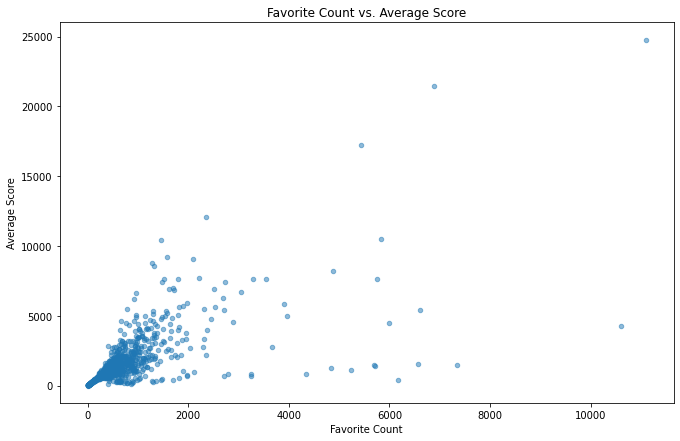

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature6["favorite_count"], feature6["avg_score"], s=20, alpha=0.50)
plt.title("Favorite Count vs. Average Score")
plt.xlabel("Favorite Count")
plt.ylabel("Average Score")

**Does this trend match with our predictions?**

As we predicted in the initial exploration, there is a positive correlation between favorite count and average score in the x-axis range 0 to 2000. However, above this range, the data is more robust, where we also see some really high favorite count with lower average scores. One possible explanation for this could be that some posts with a high favorite count may not be resourceful -- for example, some users post jokes on StackOverflow.  A funny joke may have a high favorite count, but may not have a high score as it may not be a 'helpful' post. 

### 7) Accepted Answer Score

Now, let's look at accepted answers.  First, we will see if there is a correlation between having an accepted answer and post score. Second, we will look at how the accepted answer score relates to the post score.

In [ ]:
%%bigquery --project $project_id feature7a
  SELECT AVG(posts.score) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers
  ON posts.accepted_answer_id = answers.id
  WHERE posts.accepted_answer_id IS NOT NULL
  UNION ALL
  SELECT AVG(posts.score) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers
  ON posts.accepted_answer_id = answers.id
  WHERE posts.accepted_answer_id IS NULL

Text(0, 0.5, 'Average Score')

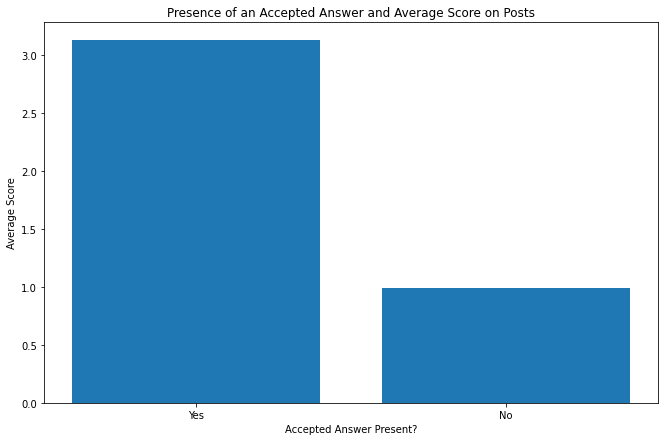

In [ ]:
plt.figure(figsize=(11, 7))
labels = ['Yes', 'No']
plt.bar(labels, feature7a['avg_score'])
plt.title("Presence of an Accepted Answer and Average Score on Posts")
plt.xlabel("Accepted Answer Present?")
plt.ylabel("Average Score")

In [ ]:
feature_7b = pd.io.gbq.read_gbq('''
  SELECT answers.score as answers_score, AVG(posts.score) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers
  ON posts.accepted_answer_id = answers.id
  WHERE posts.accepted_answer_id IS NOT NULL
  GROUP BY answers_score
''', project_id='cs145dmds-296003', dialect='standard')


Text(0, 0.5, 'Average Post Score')

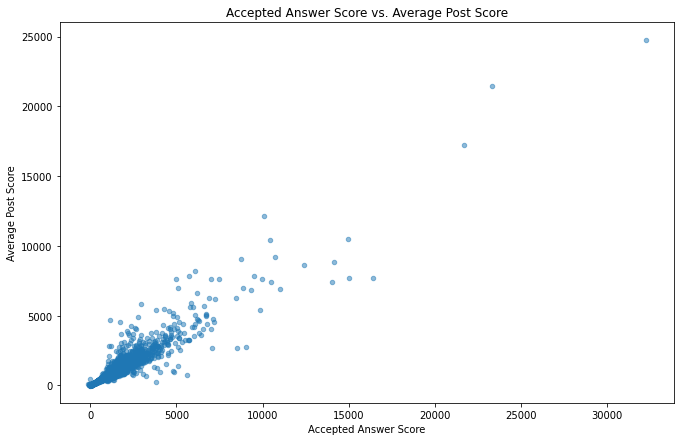

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature_7b["answers_score"], feature_7b["avg_score"], s=20, alpha=0.50)
plt.title("Accepted Answer Score vs. Average Post Score")
plt.xlabel("Accepted Answer Score")
plt.ylabel("Average Post Score")


**Does having an accepted answer have a correlation to a post having a high score?**

From the bar graph, we can see that the average score for a post without an accepted answer vs. a post with an accepted answer is significantly different.  Posts with an accepted answer average much higher scores, indicating that this feature may be highly correlated to score.  Intuitively, this makes sense as posts with an accepted answer are likely to have multiple answers, indicating that multiple people have viewed/shown interest in the post.  

**Is there a correlation between accepted answer score and post score? Does this make sense?**

Looking at the scatterplot above, we can see that there is a strong positive correlation between accepted answer score and the average post score.  As from our prediction in the initial exploration, this is possible because a high accepted answer score may imply that the post was viewed by a lot of people, and that the answer helped a lot of people. This may imply that many people had the same question, which can lead to a higher post score.

#### 8) Tag Names Used

Now, let's explore Tag Names. We will first look at how different stackoverflow tags relate to the average score of all posts the tag has appeared in. 

In [ ]:
%%bigquery --project $project_id feature_8a
  SELECT ROUND(AVG(score), 2) as avg_score, tag
  FROM (SELECT id, split(tags,'|') as tag_name, score
        FROM `bigquery-public-data.stackoverflow.posts_questions`) as ques, 
        UNNEST(tag_name) as tag
  GROUP BY tag
  ORDER BY avg_score DESC
  LIMIT 30

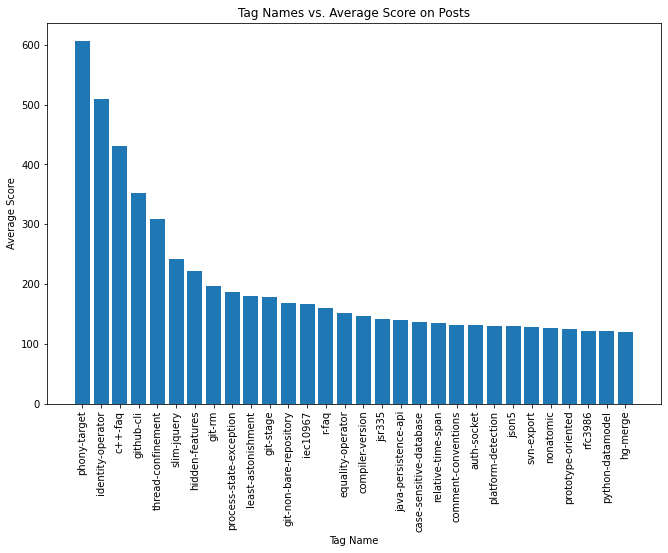

In [ ]:
plt.figure(figsize=(11, 7))
plt.bar(feature_8a['tag'], feature_8a['avg_score'])
plt.title("Tag Names vs. Average Score on Posts")
plt.xlabel("Tag Name")
plt.ylabel("Average Score")
plt.xticks(rotation='vertical')
plt.show()

**Do the top tags used as seen from the Tag Distribution in the initial exploration have high scores as in our prediction? Why might this be?**

Contrary to our prediction, top tags do not appear to have higher scores. Originally, we did not consider that since the top tags are very general (i.e. `javascript`), there may be a lot of basic or repetitive posts that would not have high scores.  On the other hand, lower tags may be more specific to a topic, and people who are looking for this specific topic may find the post useful and leave an upvote. 

To see how more common tag names perform, we then looked at the average scores for tags with a count of greater than 50,000 (see query below).  


In [ ]:
%%bigquery --project $project_id feature_8b
  SELECT ROUND(AVG(score), 2) as avg_score, tag
    FROM (SELECT id, split(tags,'|') as tag_name, score
          FROM `bigquery-public-data.stackoverflow.posts_questions`) as ques, 
          UNNEST(tag_name) as tag
  GROUP BY tag
  HAVING COUNT(tag) > 50000
  ORDER BY avg_score DESC
  LIMIT 20


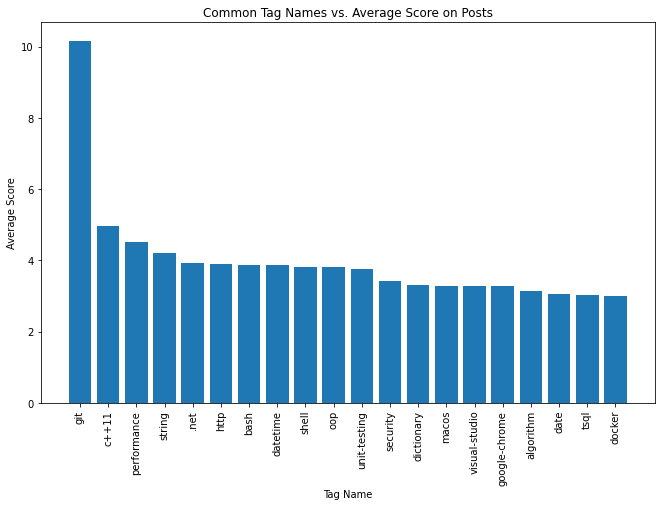

In [ ]:
plt.figure(figsize=(11, 7))
plt.bar(feature_8b['tag'], feature_8b['avg_score'])
plt.title("Common Tag Names vs. Average Score on Posts")
plt.xlabel("Tag Name")
plt.ylabel("Average Score")
plt.xticks(rotation='vertical')
plt.show()

**What might explain the big difference between git and the other tags?**

When we filtered the query for the most common tags used, we see that the average scores are significantly lower than the average scores for the top tag names overall, likely due to the high frequent usage of the tags. Among the top 20, `git` is leading by a significant amount. This could be because `git` is a relatively new version control software and has become widely used; and as a result, posts with this tag might be highly visited, searched-for, and up-voted.


#### 9) The Number of Links to a Related Post

Let’s then look at how the number of links found in a post relates to the average score. 

In [ ]:
feature_9 = pd.io.gbq.read_gbq('''
  SELECT COUNT(links.id) as num_links, AVG(score) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  LEFT JOIN `bigquery-public-data.stackoverflow.post_links` as links ON links.post_id = posts.id
  GROUP BY posts.id
''', project_id='cs145dmds', dialect='standard')

(-1.0, 40.0)

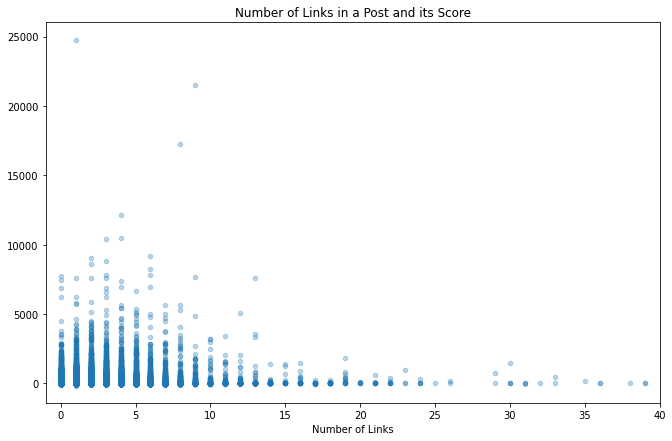

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature_9["num_links"], feature_9["avg_score"], s=20, alpha=0.30)
plt.title("Number of Links in a Post and its Score")
plt.xlabel("Number of Links")
plt.xlim(-1, 40)

**What is the overall trend for the distribution? Why might that be?**

The average score count is highest when there are 0 to 3 links.  From there on, the average score starts to slowly decrease. This makes sense because posts with fewer links are easier to read (users do not have to go back and forth between posts) and also, because they have not yet been answered by other related posts. 1 or 2 links can definitely supplement the content of the original post; however, if too many links are present, the score is more likely to be outsourced to links of related posts instead.


### 10) The Number of Revisions

Here, we look at how the number of revisions on a post will affect the score. Specifically, we looked at revisions where the title has been changed (post_history_id = 4), a post’s body has been changed - with the raw text as markdown (post_history_id = 5), and a post’s tags have been changed (post_history_id = 6). We also take into account the average score of posts with no revisions. 

In [ ]:
feature10 = pd.io.gbq.read_gbq(''' 
  SELECT posts.score as score, num_revisions
  FROM (
  SELECT COUNT(history.id) as num_revisions, history.post_id
    FROM `bigquery-public-data.stackoverflow.post_history` as history
    WHERE history.post_history_type_id = 4 OR post_history_type_id = 5 
    OR post_history_type_id = 6
    GROUP BY history.post_id
  ), `bigquery-public-data.stackoverflow.posts_questions` as posts
  WHERE posts.id = post_id
''', project_id='cs145dmds', dialect='standard')

(-11.9, 100.0)

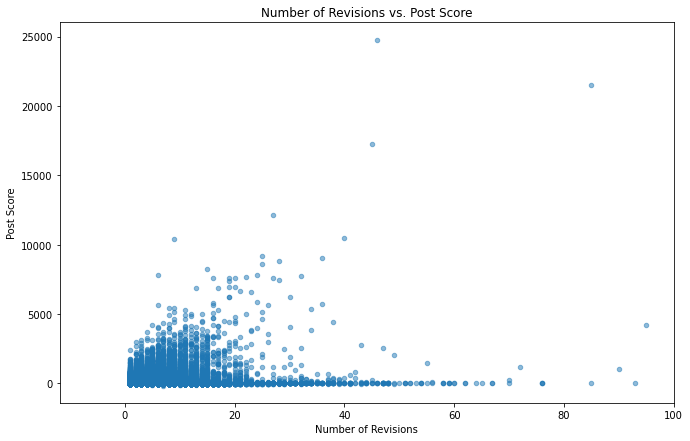

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(feature10["num_revisions"], feature10["score"], s=20, alpha=0.50)
plt.title("Number of Revisions vs. Post Score")
plt.xlabel("Number of Revisions")
plt.ylabel("Post Score")
plt.xlim(right=100)

**What might explain this trend? How does the trend shed light on what makes a ‘good’ post?**

Let’s look at the range where the most posts are concentrated — 0-20 revisions.  We can see that the trend in this range invalidates our prediction that posts with high number of revisions are more likely to get lower scores.  From the scatterplot, we can see that from the range 0 to ~15 revisions, posts have increasingly higher average scores. This might be because these posts are being revised to include a related post link, or being edited to make the post clearer to understand, which may lead to a higher post score.  Beyond ~15 revisions however, we then see a downward trend in score as the number of revisions increases, which follows with our prediction. 



### **Engineered features:**

Additionally, we will examine how score correlates with the following engineered features:

*   Time Difference from Post Creation Date to Last Activity Date
*   Time Difference From Post Creation Date to Last Edit Date
*   Time Difference From Post Creation Date to First Answer Date
*   Difference in revision length of contents
*   Difference in revision length of titles 


---




#### Time Difference from Creation Date to Last Activity Date for a Post vs. Average Score

Let's start by looking at the time difference between a post's creation and its last activity, and see how it relates to a post's average score. We chose this feature because intuitively, a post with a longer time span from creation to its last activity has had a longer period of engagement, and thus, is more likely to have a higher score. 

In [ ]:
engineered_1 = pd.io.gbq.read_gbq('''
  SELECT ROUND(AVG(posts.score), 2) as avg_score, TIMESTAMP_DIFF(last_activity_date, creation_date, MINUTE) as time_span
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  GROUP BY time_span
  HAVING time_span > 0
''', project_id='cs145dmds', dialect='standard')

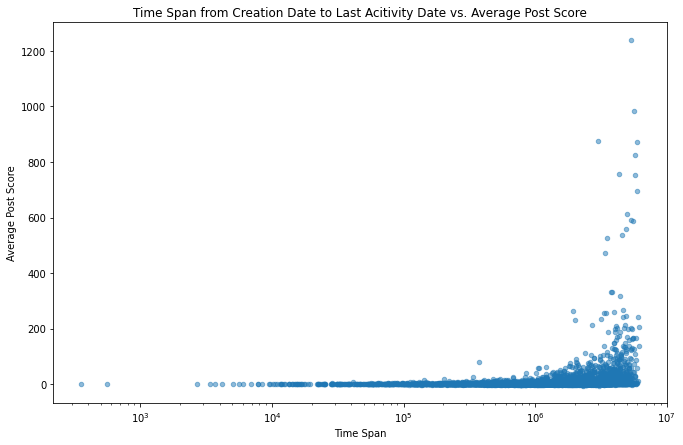

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(engineered_1["time_span"].sample(n=5000, random_state=1), engineered_1["avg_score"].sample(n=5000, random_state=1), s=20, alpha=0.50)
plt.title("Time Span from Creation Date to Last Acitivity Date vs. Average Post Score")
plt.xlabel("Time Span")
plt.ylabel("Average Post Score")
plt.xscale('log')

**Feature Description**

We decided to look at time span of a post because this could be an indication of how long the activities of a 'good' post can last. The engineered feature, which is calculated by taking the difference in the last activity date and creation date (with a difference in minutes), reveals a trend that matches our prediction -- as the time span increases, we generally see higher average post scores.

</br>

**Is this engineered feature a good contributing factor to what makes a 'good' post?**

We can conclude that posts with high average post scores are very likely to have longer activity. This makes sense because post scores are higher when there is consistent engagement with the community. This could also tie into how a 'good' post may appear in more searches over a longer period of time. However, a pitfall of this feature is that it might be biased towards posts that are older. To address this, we will also look at the difference between post creation date and last edit date as well as the difference between post creation date and creation date of the first answer.


---



#### Time Difference From Creation Date to Last Edit Date vs. Average Post Score

Next, we will look at timespan from a post's creation date to its last edit date. 

In [ ]:
engineered_2 = pd.io.gbq.read_gbq('''
  SELECT ROUND(AVG(posts.score), 2) as avg_score, TIMESTAMP_DIFF(last_edit_date, creation_date, MINUTE) as time_span
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  GROUP BY time_span
''', project_id='cs145dmds', dialect='standard')

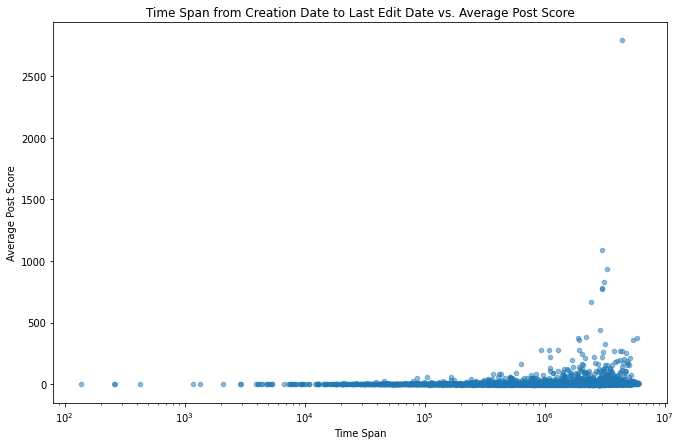

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(engineered_2["time_span"].sample(n=5000, random_state=1), engineered_2["avg_score"].sample(n=5000, random_state=1), s=20, alpha=0.50)
plt.title("Time Span from Creation Date to Last Edit Date vs. Average Post Score")
plt.xlabel("Time Span")
plt.ylabel("Average Post Score")
plt.xscale('log')

**How does this trend compare with the previous trend that used `last_activity_date`?**

The trend for both plots is similar. There is possible because the last edit date may often be the last activity date as well.

</br>

**Is this engineered feature a good contributing factor to what makes a 'good' post?**

We can conclude that posts with high average post scores have current edits that are made later from the creation date than earlier. One reason for this is that a post might have more edits - this is consistent with our results for the 'Number of Revisions vs Post Score' visualization. Another reason could be that a post already has high engagement, so more users are likely to look at it and make edits over time. And the more substantial edits are made (within a reasonable range), the better a post will be. As a result, the post will continuously reign in more votes.  Another possible reason for the higher average score is that sometimes users edit their own post to add an Update/Answer to their own question.  This can lead to a higher score for the post, as other people searching for the same question may find the Answer useful.


---



#### Time Difference from Post Creation Date to First Answer Date vs. Average Score

Next, let’s look at the difference between the post creation date and the date of the first answer to the post, and see how this difference may relate to a post’s score.  We wanted to look at this feature because intuitively, a post that is popular initially (i.e. receives a quick first answer) may end up with more engagement overall, and thus, have a higher score.

In [ ]:
%%bigquery --project $project_id engineered_3
  SELECT TIMESTAMP_DIFF(dates.earliest_answer, dates.creation_date, MINUTE) as time_span,
        ROUND(AVG(posts.score), 2) as avg_score
  FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
  JOIN (SELECT p.id, p.creation_date, MIN(a.creation_date) as earliest_answer
        FROM `bigquery-public-data.stackoverflow.posts_questions` p
        JOIN `bigquery-public-data.stackoverflow.posts_answers` a ON a.parent_id=p.id
        WHERE p.answer_count > 0 AND a.creation_date IS NOT NULL
        GROUP BY p.id, p.creation_date
        HAVING earliest_answer > p.creation_date) dates ON dates.id=posts.id
  GROUP BY time_span
  ORDER BY avg_score DESC

Text(0, 0.5, 'Average Score')

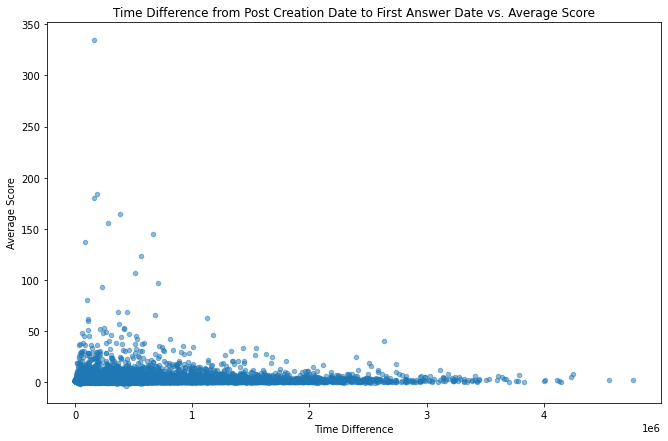

In [ ]:
df = pd.DataFrame(engineered_3)
engineered_3_sample = df.sample(10000)

plt.figure(figsize=(11, 7))
plt.scatter(engineered_3_sample["time_span"], engineered_3_sample["avg_score"], s=20, alpha=0.50)
plt.title("Time Difference from Post Creation Date to First Answer Date vs. Average Score")
plt.xlabel("Time Difference")
plt.ylabel("Average Score")

**Is there a correlation between this engineered feature and a post’s score? Why might this be?**

There appears to be a slight correlation between the time difference of a post creation and the first answer vs. the post score.  We can see from the plot that there is a slight downwards trend as the time difference increases — in other words, posts that receive an answer relatively quickly tend to average slightly higher scores.  We can also see that posts with extremely high scores all had a relatively small time difference between the post creation and its first answer.  

This is likely because posts that receive a fast reply may be focused on more popular topics.  Furthermore, when a post receives a reply, that may increase the chances another user engages with it, which can lead to even more users engaging with the post, and ultimately lead to a higher post score.

#### Revised Post Length Difference vs. Average Score

We will first look at how the amount of revision for a post may affect its score, then compare this to how revising the post's title can affect its score.

In [ ]:
engineered_3a = pd.io.gbq.read_gbq('''
  SELECT ROUND(avg_revision_len - LENGTH(body), 2) as diff_len, avg_score
  FROM (
    SELECT AVG(LENGTH(hist.text)) as avg_revision_len, posts.body, AVG(posts.score) as avg_score
    FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
    JOIN `bigquery-public-data.stackoverflow.post_history` as hist
    ON posts.id = hist.post_id
    WHERE post_history_type_id = 5 --EDIT BODY
    GROUP BY posts.id, posts.body
  )
''', project_id='cs145dmds', dialect='standard')

(-5000.0, 4000.0)

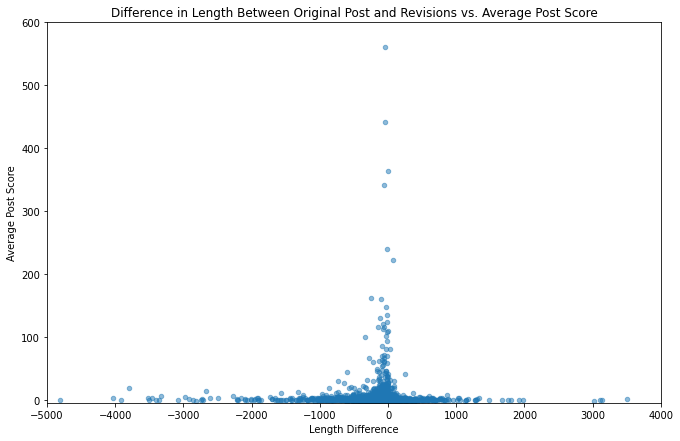

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(engineered_3a["diff_len"].sample(n=5000, random_state=1), engineered_3a["avg_score"].sample(n=5000, random_state=1), s=20, alpha=0.50)
plt.title("Difference in Length Between Original Post and Revisions vs. Average Post Score")
plt.xlabel("Length Difference")
plt.ylabel("Average Post Score")
plt.ylim(-5, 600)
plt.xlim(-5000, 4000)

**Feature Description**

The engineered feature, which is calculated by subtracting the original content (which also contains raw markup) from the revised content, reveals a trend where most of the posts with high scores do not have drastic revisions.

</br>

**Is this engineered feature a good contributing factor to what makes a 'good' post?**

We can conclude that posts with revisions that delete or add a lot of content are very likely to have lower scores. This might be due to situations where a change is so drastic that it makes already posted answers irrelevant or confusing. The data is just slightly skewed to the negative because of the inclusion of markup in the original post.


---



#### Revised Post Title Difference vs. Average Score

Now let's see how the difference between the original post title and the revised post title may correlate with the post score.

In [ ]:
engineered_3b = pd.io.gbq.read_gbq('''
  SELECT ROUND(avg_revision_len - LENGTH(title), 2) as diff_len, avg_score
  FROM (
    SELECT AVG(LENGTH(hist.text)) as avg_revision_len, posts.title, AVG(posts.score) as avg_score
    FROM `bigquery-public-data.stackoverflow.posts_questions` as posts
    JOIN `bigquery-public-data.stackoverflow.post_history` as hist
    ON posts.id = hist.post_id
    WHERE post_history_type_id = 4 --EDIT TITLE
    GROUP BY posts.id, posts.title
  )
''', project_id='cs145dmds', dialect='standard')

Text(0, 0.5, 'Average Post Score')

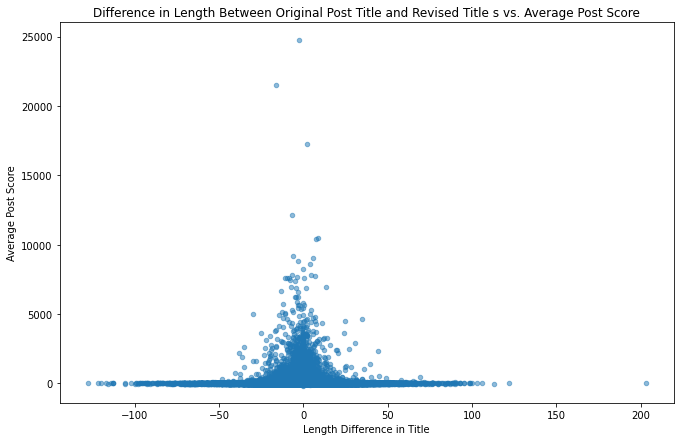

In [ ]:
plt.figure(figsize=(11, 7))
plt.scatter(engineered_3b["diff_len"], engineered_3b["avg_score"], s=20, alpha=0.50)
plt.title("Difference in Length Between Original Post Title and Revised Title s vs. Average Post Score")
plt.xlabel("Length Difference in Title")
plt.ylabel("Average Post Score")


**How does this trend compare with the previous trend that used `last_activity_date`?**

The trend is more spread out than before. A reason for this might be that titles are shorter, so any small changes can make a bigger impact.

</br>

**Is this engineered feature a good contributing factor to what makes a 'good' post?**

Here, we can see that titles that are revised as little as possible have higher average scores. This means that a title, once published, that stays the same for the entirety of a post's life tends to have a higher average score.  This may be because users who edit the post title are doing so because it was not clear originally.  If a post title is already clear and concise, the user will likely not edit the title.  


---


### **Analysis and Summary of Observations -- what Makes a Good Post?**

**Which features are especially prominent?**

As mentioned in our analysis earlier, there are a few features that appear to be correlated with post score.  Features that appear to be especially prominent and produce the strongest correlations are: the user's badge class, post title length, post favorite count, accepted answer score and whether or not it has an accepted answer, as well as the post's owner reputation score. 

</br>

**What trends can be seen?**

From our analysis of badge class, we saw that users with a gold badge tend to average higher scores compared to users with a bronze badge.  We also found that high scoring posts tend to average a title length of around 30-60 characters.  The trend for favorite count was as predicted -- higher favorite counts for a post tend to relate to a higher post score.  

Another trend can be seen from the big gap between average scores for posts without an accepted answer and scores for posts with an accepted answer (where the accepted answer score also grows proportionately with the post score). This gap might be caused by the tendency of viewers to reach posts that already have a credible/accepted answer. This may increase the post's reliability in a users eyes.  These trends give us some insight into what makes a 'good' StackOverflow post question.

</br>

In addition, we also looked at a few engineered features.  Through these features we saw that a posts with long time spans from their creation date to their last activity date tend to average higher scores compared to posts with a short time span.  Furthermore, posts that receive an answer relatively quickly also tend to average slightly higher scores.  These time span related features may be an indicator of engagement levels for posts -- fast answers and a longer creation-activity time span may indicate higher engagement, which may lead to a higher post score. 

</br> 

**Are there anomalies?**

One of the anomalies is the flatness of the post content length scatterplot. The little correlation that can be seen contradicts with our prediction that posts that have a lower average length will have higher scores. We hypothesized that a reason for this might be the difference in question topics - meaning that some questions are good only if more context are given, whereas more general questions can be good without too many details or code. This can mean that posts with very different post length may still have similar scores.

## **Data Prediction**

### **Prediction Problem**

Given attributes of a post and its corresponding user, can we predict whether a post will be a 'good' post? In other words, can we predict whether this post will have a high score? For our problem, let's define a high score as a score > 5 .


### **Dataset to Store Model**

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'stackoverflow_scoring'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('cs145dmds-296003', 'stackoverflow_scoring'))

### **Separation of Dataset**


First, since it's important to have separate datasets to train, evaluate, and test your model, we split our dataset into 3 subsets.

**Training set**: we'll train on posts created between 2014-2018  (`creation_date` < '2018-01-01' and `creation_date` >= '2014-01-01').

**Evaluation set**: We'll evaluate on the next year (`creation_date` between '2018-01-01' and '2019-01-01').

**Test set**: We'll test on the year 2019 (`creation_date` between '2019-01-01' and '2020-01-01').

Now, let's train a simple model. 

### **Train our Simple Model**

For this simple model, we will only use our non-engineered features. Specifically, we will use the following features: 

* User Badge Class
* Post Title Length
* Has or Does Not Have Accepted Answer
* Post's Owner (User) Reputation Score

We chose to use these features due to our observations in the exploration of the dataset.  These were *some* of the features that were shown to be correlated with post score.  



In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `stackoverflow_scoring.scoring_model` 
OPTIONS(model_type='logistic_reg') AS
SELECT 
  case when qs.score > 5 then 1 else 0 end AS label,
  user_badge_class,
  LENGTH(qs.title) as post_title_length,
  case when qs.accepted_answer_id IS NOT NULL then 1 else 0 end AS has_accepted,
  us.reputation as user_reputation
FROM `bigquery-public-data.stackoverflow.posts_questions` as qs
JOIN `bigquery-public-data.stackoverflow.users` as us ON qs.owner_user_id=us.id
JOIN (SELECT bs.user_id, MIN(bs.class) as user_badge_class 
      FROM `bigquery-public-data.stackoverflow.badges` as bs
      GROUP BY bs.user_id) badges ON badges.user_id=us.id
WHERE EXTRACT(YEAR from qs.creation_date AT TIME ZONE "UTC") BETWEEN 2014 AND 2018

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `stackoverflow_scoring.scoring_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,8,0.164304,0.167383,51.2,22834
1,0,7,0.165181,0.168323,25.6,22229
2,0,6,0.169505,0.173157,12.8,22795
3,0,5,0.184397,0.187617,6.4,24816
4,0,4,0.232552,0.234954,3.2,25091
5,0,3,0.336645,0.338155,1.6,24363
6,0,2,0.469433,0.470243,0.8,25655
7,0,1,0.580357,0.580728,0.4,25654
8,0,0,0.652265,0.652393,0.2,15113


### **Evaluate our Simple Model**

Recall for our evaluation set, we're evaluating on the year 2018 (`creation_date` between '2018-01-01' and '2019-01-01'). 



In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflow_scoring.scoring_model`, (
SELECT 
  case when qs.score > 5 then 1 else 0 end AS label,
  user_badge_class,
  LENGTH(qs.title) as post_title_length,
  case when qs.accepted_answer_id IS NOT NULL then 1 else 0 end AS has_accepted,
  us.reputation as user_reputation
FROM `bigquery-public-data.stackoverflow.posts_questions` as qs
JOIN `bigquery-public-data.stackoverflow.users` as us ON qs.owner_user_id=us.id
JOIN (SELECT bs.user_id, MIN(bs.class) as user_badge_class 
      FROM `bigquery-public-data.stackoverflow.badges` as bs
      GROUP BY bs.user_id) badges ON badges.user_id=us.id
WHERE EXTRACT(YEAR from qs.creation_date AT TIME ZONE "UTC") = 2018))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.262664,0.002828,0.97264,0.005596,0.115878,0.748843


### **Improving our Model**

Our model seems to be doing pretty well in terms of accuracy.  Let's try to add some more features to see if we can make it more precise! Let's add these features: 

* (Simple) Favorite Count
* (Engineered) Time span from creation date to last activity date 
* (Engineered) Time difference from post creation date to first answer date

We chose to add Favorite Count since it appears to have a relatively strong relation with post score from our data exploration, and the two time span features since they appeared to be slightly correlated with post score from our exploration. 

#### Let's start by retraining our model including the engineered features



In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `stackoverflow_scoring.scoring_model_v2`
OPTIONS(model_type='logistic_reg') AS
SELECT 
  case when qs.score > 5 then 1 else 0 end AS label,
  badges.user_badge_class,
  qs.favorite_count,
  LENGTH(qs.title) as post_title_length,
  case when qs.accepted_answer_id IS NOT NULL then 1 else 0 end AS has_accepted,
  us.reputation as user_reputation,
  TIMESTAMP_DIFF(qs.last_activity_date, qs.creation_date, MINUTE) as activity_timespan,
  TIMESTAMP_DIFF(dates.earliest_answer, dates.creation_date, MINUTE) as answer_timespan
FROM `bigquery-public-data.stackoverflow.posts_questions` as qs
JOIN `bigquery-public-data.stackoverflow.users` as us ON qs.owner_user_id=us.id
JOIN (SELECT bs.user_id, MIN(bs.class) as user_badge_class 
      FROM `bigquery-public-data.stackoverflow.badges` as bs
      GROUP BY bs.user_id) badges ON badges.user_id=us.id
JOIN (SELECT p.id, p.creation_date, MIN(a.creation_date) as earliest_answer
        FROM `bigquery-public-data.stackoverflow.posts_questions` p
        JOIN `bigquery-public-data.stackoverflow.posts_answers` a ON a.parent_id=p.id
        WHERE p.answer_count > 0 AND a.creation_date IS NOT NULL
        GROUP BY p.id, p.creation_date
        HAVING earliest_answer > p.creation_date) dates ON dates.id=qs.id
WHERE EXTRACT(YEAR from qs.creation_date AT TIME ZONE "UTC") BETWEEN 2014 AND 2018

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `stackoverflow_scoring.scoring_model_v2`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,9,0.140997,0.145717,12.8,20337
1,0,8,0.142079,0.146612,6.4,21082
2,0,7,0.143199,0.148309,25.6,20730
3,0,6,0.150804,0.154954,12.8,20653
4,0,5,0.171283,0.174930,6.4,21121
5,0,4,0.225115,0.227773,3.2,21931
6,0,3,0.332518,0.334131,1.6,22969
7,0,2,0.466931,0.467793,0.8,19656
8,0,1,0.579004,0.579410,0.4,23053
9,0,0,0.651744,0.651890,0.2,15087


Now, let's reevaluate our newly trained model!

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflow_scoring.scoring_model_v2`, (
SELECT 
  case when qs.score > 5 then 1 else 0 end AS label,
  badges.user_badge_class,
  qs.favorite_count,
  LENGTH(qs.title) as post_title_length,
  case when qs.accepted_answer_id IS NOT NULL then 1 else 0 end AS has_accepted,
  us.reputation as user_reputation,
  TIMESTAMP_DIFF(qs.last_activity_date, qs.creation_date, MINUTE) as activity_timespan,
  TIMESTAMP_DIFF(dates.earliest_answer, dates.creation_date, MINUTE) as answer_timespan
FROM `bigquery-public-data.stackoverflow.posts_questions` as qs
JOIN `bigquery-public-data.stackoverflow.users` as us ON qs.owner_user_id=us.id
JOIN (SELECT bs.user_id, MIN(bs.class) as user_badge_class 
      FROM `bigquery-public-data.stackoverflow.badges` as bs
      GROUP BY bs.user_id) badges ON badges.user_id=us.id
JOIN (SELECT p.id, p.creation_date, MIN(a.creation_date) as earliest_answer
        FROM `bigquery-public-data.stackoverflow.posts_questions` p
        JOIN `bigquery-public-data.stackoverflow.posts_answers` a ON a.parent_id=p.id
        WHERE p.answer_count > 0 AND a.creation_date IS NOT NULL
        GROUP BY p.id, p.creation_date
        HAVING earliest_answer > p.creation_date) dates ON dates.id=qs.id
WHERE EXTRACT(YEAR from qs.creation_date AT TIME ZONE "UTC") = 2018))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.969424,0.064455,0.970516,0.120874,0.110425,0.830289


**How did adding these features change the accuracy and precision of our model?** 

While our accuracy is slightly lower after adding the features, our precision is significantly higher. This means that our model's measured values are now significantly closer to each other, while still being relatively accurate. 

**Why might have accuracy decreased after adding these features?**

While the timespan features we added appeared to be slightly correlated with post score as from our exploration of the datat, it's possible that accuracy decreased since they were less correlated than expected. 



### **Evaluate Final Model on Test Set**

Recall that for our test set, we're using the year 2019 (posts with `creation_date` between '2019-01-01' and '2020-01-01').

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `stackoverflow_scoring.scoring_model_v2`, (
SELECT 
  case when qs.score > 5 then 1 else 0 end AS label,
  badges.user_badge_class,
  qs.favorite_count,
  LENGTH(qs.title) as post_title_length,
  case when qs.accepted_answer_id IS NOT NULL then 1 else 0 end AS has_accepted,
  us.reputation as user_reputation,
  TIMESTAMP_DIFF(qs.last_activity_date, qs.creation_date, MINUTE) as activity_timespan,
  TIMESTAMP_DIFF(dates.earliest_answer, dates.creation_date, MINUTE) as answer_timespan
FROM `bigquery-public-data.stackoverflow.posts_questions` as qs
JOIN `bigquery-public-data.stackoverflow.users` as us ON qs.owner_user_id=us.id
JOIN (SELECT bs.user_id, MIN(bs.class) as user_badge_class 
      FROM `bigquery-public-data.stackoverflow.badges` as bs
      GROUP BY bs.user_id) badges ON badges.user_id=us.id
JOIN (SELECT p.id, p.creation_date, MIN(a.creation_date) as earliest_answer
        FROM `bigquery-public-data.stackoverflow.posts_questions` p
        JOIN `bigquery-public-data.stackoverflow.posts_answers` a ON a.parent_id=p.id
        WHERE p.answer_count > 0 AND a.creation_date IS NOT NULL
        GROUP BY p.id, p.creation_date
        HAVING earliest_answer > p.creation_date) dates ON dates.id=qs.id
WHERE EXTRACT(YEAR from qs.creation_date AT TIME ZONE "UTC") = 2018))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.969424,0.064455,0.970516,0.120874,0.110425,0.830289


**What does it mean for our model to have high precision?**

High precision indicates that the predictions our model is making do not vary significantly (i.e. the predictions are similar to each other). A high accuracy along with a high precision is typically a good metric to observe.  

**What does it mean for the model to have low recall?**

It means that our model may be inaccurately predicting some of the 'good' posts as not good.  

**How is the overall performance of our model?**

It is likely that posts that our model predicts to be 'good' *are* accurately good posts (due to the high accuracy score); however, our model may classify some of the other 'good' posts as bad inaccurately. 

**What metrics did we use to evaluate our performance?**

Aside from looking at the precision, recall, and accuracy, we also looked at the log loss and `roc_auc`.  Looking at the log loss of the logistic regression model, we can see that our final model with the engineered features and `favorite_count` performed better than the simple model earlier, as the log loss is now lower. We can also see that the `roc_auc` is 0.83 in for our final model, and 0.75 for our earlier model. Since 0.5 is the baseline for random guessing, we can see that our models are predicting values better than random guessing, and that our final model performance is better than our simple model. 

### **Prediction Time!**

Now let's use our model to make some predictions! Let's predict on posts created in 2019, to see how they differ from the actual scores of posts in 2019.  

Let's display the features used for prediction and the predicted label for 50 examples. The predicted label will be called predicted_label.

In [ ]:
%%bigquery --project $project_id

SELECT
  user_badge_class,
  favorite_count,
  post_title_length,
  has_accepted,
  user_reputation,
  activity_timespan,
  answer_timespan,
  predicted_label
FROM
  ML.PREDICT(MODEL `stackoverflow_scoring.scoring_model_v2`, ( 
SELECT 
  case when qs.score > 5 then 1 else 0 end AS label,
  bs.class as user_badge_class,
  qs.favorite_count,
  LENGTH(qs.title) as post_title_length,
  case when qs.accepted_answer_id IS NOT NULL then 1 else 0 end AS has_accepted,
  us.reputation as user_reputation,
  TIMESTAMP_DIFF(qs.last_activity_date, qs.creation_date, MINUTE) as activity_timespan,
  TIMESTAMP_DIFF(dates.earliest_answer, dates.creation_date, MINUTE) as answer_timespan
FROM `bigquery-public-data.stackoverflow.posts_questions` as qs
JOIN `bigquery-public-data.stackoverflow.users` as us ON qs.owner_user_id=us.id
JOIN `bigquery-public-data.stackoverflow.badges` as bs ON bs.user_id=us.id
JOIN (SELECT p.id, p.creation_date, MIN(a.creation_date) as earliest_answer
        FROM `bigquery-public-data.stackoverflow.posts_questions` p
        JOIN `bigquery-public-data.stackoverflow.posts_answers` a ON a.parent_id=p.id
        WHERE p.answer_count > 0 AND a.creation_date IS NOT NULL
        GROUP BY p.id, p.creation_date
        HAVING earliest_answer > p.creation_date) dates ON dates.id=qs.id
WHERE EXTRACT(YEAR from qs.creation_date AT TIME ZONE "UTC") = 2019
      AND MOD(CAST(12186710727 * RAND() AS INT64), 10000) = 1)) # 2671 rows sampled
ORDER BY predicted_label DESC
LIMIT 50

,user_badge_class,favorite_count,post_title_length,has_accepted,user_reputation,activity_timespan,answer_timespan,predicted_label
0,2,NaN,42,1,732971,1449,294,1
1,1,1.0,47,1,314792,711154,21,1
2,2,1.0,58,1,779262,5497,5492,1
3,2,NaN,42,0,543672,86,85,1
4,2,1.0,71,1,869424,3013,3013,1
5,3,8.0,54,1,410395,612552,695,1
6,2,1.0,50,1,647797,152256,170,1
7,3,0.0,49,1,647797,443,443,1
8,3,1.0,58,1,779262,5497,5492,1
9,2,5.0,46,1,410395,66723,66538,1


**What do our model's predictions look like?**

Out of a sampling of 2671 rows (shuffled from the original table), our model predicted 24 to have a score of 1.  In other words, our model predicted 25/2671 = 0.94% of posts in 2019 to be 'good' posts with a score of > 5.  

**How does this compare to the true result?**

In reality, 22635 posts created in 2019 currently have a post score of > 5, and 1,349,390 do not.  This would mean 22635/1372025 = 1.6% of posts in 2019 are 'good' posts.  

**Which features appear to be affecting the predicted label?**

We can see from the chart above that user reputation seems to be strongly correlated with the predictive label -- the majority of posts that were deemed to be 'good' posts had users with reputation score > 100,000, whereas the majority of posts that were not deemed to be 'good' posts had users with reputation score in the thousands or tens of thousands.  

Whether or not the post has an accepted answer also appears to be strongly correlated with the model's predicted label.  Most of the posts that were deemed to be 'good' posts also had an accepted answer.  This follows from what we saw in our exploration as well.  

Lastly, favorite count appears to be correlated with the model's predictive label as well.  Out of the 25 posts that received a predicted score of '1', 11 had a favorite count of >= 1.  Out of the 25 posts that received a predicted score of '0', only 5 had a favorite count of >= 1.  

## **Conclusion**


To answer our central question of what makes a 'good' question post, which we defined as posts with a high score (upvotes - downvotes), we explored multiple features such as post length, tags, title, favorite count, and answer count. Digging deeper into the connections between the tables, we also explored how features such as the post owner's badge type and reputation, the presence of an accepted answer, as well as the number of links and revisions a post has, may affect a post's score. For engineered features, we saw how time differences and the length of post revisions may correlate with post scores. Lastly, for our trained model, we defined a good post as one having a score greater than 5.   

</br>

**What is obvious, and what did you not expect to see? What conclusions have you made or been unable to make about your dataset and why? What are some places where we could have done more exploration?**

Predictions that were more obvious included the correlation between high post scores and high favorite counts, as well as the correlation between high post scores and their accepted answer scores. We also predicted correctly that having or not having an accepted answer would affect the average score of a post. Explanations for these patterns are somewhat intuitive - users have tendencies to favorite posts that are reliable and have been answered already (has an accepted answer). 

However, other trends we saw were not as intuitive. For example, we predicted that badges that are less related to a user's questions and answers are more unlikely to affect a post score. From the deeper exploration, one surprising anomaly was that the Synonymizer badge averaged the highest score (we specifically examined badges that are bronze more closely because the vast majority of users hold bronze badges). We realized that this badge appeared less frequently and it is likely that users who have approved tag synonyms are more ardent StackOveflow users. Without further exploration into the statistics of those users, we cannot make more conclusions. 

While we predicted correctly that posts with shorter title lengths will have higher scores, we predicted wrongly for the content length. This is one of the more unexpected results we got, where we saw that there was essentially no visible correlation between post length and score. This might be due to the following reasons: question length is highly dependent on the topic (for example, some topics have a lot of content dedicated to just code, while others might just need one or two lines of description but still garner a lot of upvotes). This is a good place for further explorations. For example, to check if our reasoning is correct, we could look at how tags compare with content length to first find the question topics, then we can link this query to post score. 

The visualization of user reputation with post score in the deeper exploration was particularly insightful because while posting questions with high scores did correspond to high reputation like we predicted, we see that for users with the highest reputations, the average score is actually quite low - this might be because those particular users contribute to the StackOverflow community as core moderators and answer writers and are highly specialized in their areas of expertise.  They may not post questions as often as a result. This could also be a place where we can do further explorations to get a better sense of those user's stats, for instance, how many questions have they answered vs. how many questions have they asked. 

</br>

**What did we learn from our engineered features and predictions?**

Some limitations of our explorations came from the number of revisions vs post score visualization. We could not make clear observations for this becuase there are many types of revisions, like a title revisions, body revision, or tags revisions. The visualization in the deeper exploration sub-section aggregated those into a single count, so we might have overlooked important factors such as the time they are revised and the individual counts of the different revision types. To address the latter issue, we decided to focus in on the difference in length of revisions for (1) the post title, and (2) the post body for two of our engineered features. In both cases, we saw that posts with little revision differences had the best scores. The time of revisions is also important because frequent revisions in shorter time can mean that the question might be harder to answer because it is always changing - this could be a good place for further explorations. 

Another engineered feature we explored was the time difference between post creation date and last activity date/last edit date. Although we did conclude that high average post score is slightly correlated with longer activity possibly because post scores are higher when there is consistent engagement with the community, a pitfall of this feature is that it might be biased towards posts that are older.  This is because older posts have had more time to be edited/made better and attract more answers. To address this, we decided to also look into the difference between post creation date and the first answer creation date, where we saw posts that receive an answer relatively quickly tend to average slightly higher scores.

From our predictions, we saw that our model only predicted 0.94% of posts to be 'good' in 2019.  The reality was slightly higher -- in 2019, 1.6% of posts had a score higher than 5.  While we expected the majority of posts to not have a score higher than 5, since many posts have a score of 0, we were still surprised by how low the percentage was.  Curious about the true numbers for other years, we looked into the true percentages of 'good' posts for other years.  

* 2015: 109955/1844949 = 5.96%
* 2016: 92903/1809248 = 5.13%
* 2017: 71049/1694400 = 4.19%
* 2018: 46730/1453974 = 3.21%
* 2019: 1.6% 
* 2020: 5858/997536 = 0.59%

Noticeably, there is a clear downwards trend by the year.  This general decrease in the ratio of good posts to all posts can be explained by several factors: 
1. The number of total posts appears to be decreasing year by year.  This is possibly because as the amount of questions on StackOverflow increase, the number of topics and specific questions already covered also increases.  Thus, people may search StackOverflow and already find that their post was already asked.   
2. Newer posts may need more time to be discovered or made relevant. This would explain the decrease in 'good' posts each year.  

Overall, our model performed better than random guessing, and is able to accurately predict when a post is 'good'.  However, as mentioned earlier, there are still many features that can be explored that would improve our model performance, especially in recall.  From our exploration and predictions, we can see that not many posts actually reach a score of 5; however, with the different features we explored such as title length and accepted answers, we now have a better sense of what factors may lead to a higher post score.  